# Trying out tensor flow

Based on the [work by Jason Baldridge](https://bcomposes.wordpress.com/2015/11/26/simple-end-to-end-tensorflow-examples/). 

We will try to do some really simple things with TensorFlow, Google's newly open-sourced data analysis library. 

Specifically, we will use TF to show the power of artificial neural networks

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.cross_validation import train_test_split

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
mpl.style.use('fivethirtyeight')

## We'll set up some configuration variables up-front:

In [5]:
# Configuration variables:
num_labels = 2    # The number of labels.
BATCH_SIZE = 100  # The number of training examples to use per training step.
NUM_EPOCHS = 5
NUM_HIDDEN = 5
n_train = 1000
n_test = 200

## Set up a function to generate datasets from functions in `scikit-learn`

In [6]:
def generate_dataset(func, n_train=n_train, n_test=n_test, num_labels=num_labels, **kwargs):
    fvecs, labels = func(n_train + n_test, **kwargs)
    # We need the one-hot encoder!
    labels_onehot = (np.arange(num_labels) == labels[:, None])
    train_data, test_data, train_labels, test_labels = train_test_split(fvecs.astype(np.float32), 
                                                                        labels_onehot.astype(np.float32), 
                                                                        train_size=n_train)
    return train_data, test_data, train_labels, test_labels 

### The first example is a linearly separable data-set:

In [7]:
train_data, test_data, train_labels, test_labels = generate_dataset(make_blobs, n_train=1000, n_test=200, 
                                                                    centers=2, center_box=[-4., 4.])

In [8]:
train_labels.shape

(1000, 2)

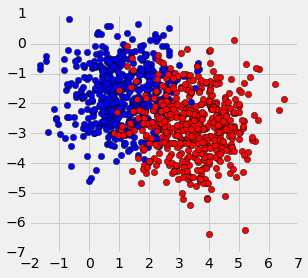

In [9]:
fig, ax = plt.subplots(1)
ax.plot(train_data[np.where(train_labels[:, 0]), 0], train_data[np.where(train_labels[:, 0]), 1], 'bo')
ax.plot(train_data[np.where(train_labels[:, 1]), 0], train_data[np.where(train_labels[:, 1]), 1], 'ro')
ax.set_aspect('equal')

In [10]:
def train_softmax(train_data, train_labels,
                  n_train=n_train,
                  num_labels=num_labels, batch_size=BATCH_SIZE,
                  num_epochs=NUM_EPOCHS):
    
    train_size, num_features = train_data.shape

    # This is where training samples and labels are fed to the graph.
    # These placeholder nodes will be fed a batch of training data at each
    # training step using the {feed_dict} argument to the Run() call below.
    x = tf.placeholder("float", shape=[None, num_features])
    y = tf.placeholder("float", shape=[None, num_labels])

    # Define and initialize the network:
    # These are the weights that inform how much each feature contributes to
    # the classification.
    W = tf.Variable(tf.zeros([num_features, num_labels]))
    b = tf.Variable(tf.zeros([num_labels]))
    y_hat = tf.nn.softmax(tf.matmul(x, W) + b)

    # Optimization:
    cross_entropy = -tf.reduce_sum(y * tf.log(y_hat))
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

    s = tf.Session()
    # Run all the initializers to prepare the trainable parameters.
    tf.initialize_all_variables().run(session=s)
    print('Initialized!')
    
    # Iterate and train:
    print('Training:')
    for step in xrange(num_epochs * train_size // batch_size):
        print(step),

        offset = (step * batch_size) % train_size
        batch_data = train_data[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size)]
        train_step.run(feed_dict={x: batch_data, y: batch_labels}, session=s)

        if offset >= train_size-batch_size:
            print

    return W, b, s

In [11]:
W, b, s = train_softmax(train_data, train_labels)

Initialized!
Training:
0 1 2 3 4 5 6 7 8 9
10 11 12 13 14 15 16 17 18 19
20 21 22 23 24 25 26 27 28 29
30 31 32 33 34 35 36 37 38 39
40 41 42 43 44 45 46 47 48 49


In [12]:
def evaluate_softmax(W, b, test_data, test_labels, s):
    test_size, num_features = train_data.shape

    # This is where training samples and labels are fed to the graph.
    # These placeholder nodes will be fed a batch of training data at each
    # training step using the {feed_dict} argument to the Run() call below.
    x = tf.placeholder("float", shape=[None, num_features])
    y_hat = tf.nn.softmax(tf.matmul(x, W) + b)
    y = tf.placeholder("float", shape=[None, num_labels])
    # Evaluation:
    correct_prediction = tf.equal(tf.argmax(y_hat, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    p_correct = accuracy.eval(feed_dict={x: test_data, y: test_labels}, session=s)
    return p_correct


In [13]:
accuracy = evaluate_softmax(W, b, test_data, test_labels, s)

In [14]:
accuracy

0.86500001

In [15]:
Wx_b =np.dot(test_data, s.run(W)) + s.run(b)

In [16]:
cls = tf.nn.softmax(Wx_b)

In [17]:
cls

In [18]:
cls_np = np.round(s.run(cls))

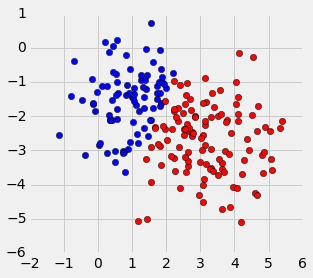

In [19]:
fig, ax = plt.subplots(1)
ax.plot(test_data[np.where(cls_np[:, 0]), 0], test_data[np.where(cls_np[:, 0]), 1], 'bo')
ax.plot(test_data[np.where(cls_np[:, 1]), 0], test_data[np.where(cls_np[:, 1]), 1], 'ro')
ax.set_aspect('equal')

### The next set of data is not linearly separable:

In [20]:
train_data, test_data, train_labels, test_labels = generate_dataset(make_moons, n_train=1000, n_test=200, noise=0.2)

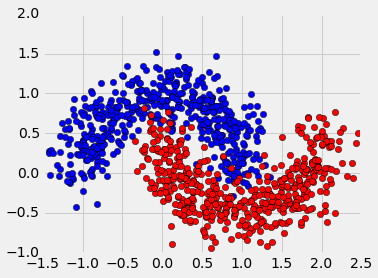

In [21]:
fig, ax = plt.subplots(1)
ax.plot(train_data[np.where(train_labels[:, 0]), 0], train_data[np.where(train_labels[:, 0]), 1], 'bo')
ax.plot(train_data[np.where(train_labels[:, 1]), 0], train_data[np.where(train_labels[:, 1]), 1], 'ro')
ax.set_aspect('equal')

### And softmax doesn't do great:

In [22]:
W, b, s = train_softmax(train_data, train_labels)
evaluate_softmax(W, b, test_data, test_labels, s)

Initialized!
Training:
0 1 2 3 4 5 6 7 8 9
10 11 12 13 14 15 16 17 18 19
20 21 22 23 24 25 26 27 28 29
30 31 32 33 34 35 36 37 38 39
40 41 42 43 44 45 46 47 48 49


0.86500001

In [23]:
cls = np.round(s.run(tf.nn.softmax(tf.matmul(test_data, W) + b)))

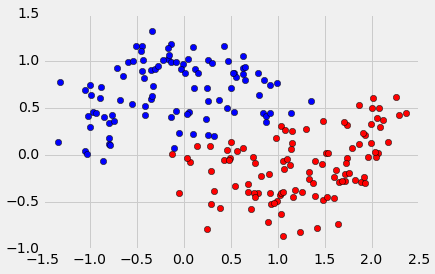

In [24]:
fig, ax = plt.subplots(1)
ax.plot(test_data[np.where(cls[:, 0]), 0], test_data[np.where(cls[:, 0]), 1], 'bo')
ax.plot(test_data[np.where(cls[:, 1]), 0], test_data[np.where(cls[:, 1]), 1], 'ro')
ax.set_aspect('equal')

In [25]:
train_data, test_data, train_labels, test_labels = generate_dataset(make_circles, n_train=1000, n_test=200, noise=0.2, factor=0.1)

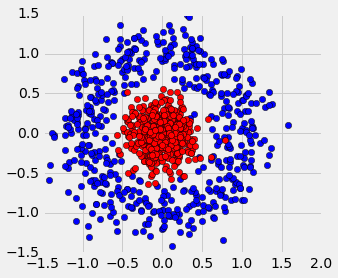

In [26]:
fig, ax = plt.subplots(1)
ax.plot(train_data[np.where(train_labels[:, 0]), 0], train_data[np.where(train_labels[:, 0]), 1], 'bo')
ax.plot(train_data[np.where(train_labels[:, 1]), 0], train_data[np.where(train_labels[:, 1]), 1], 'ro')
ax.set_aspect('equal')

In [27]:
W, b, s = train_softmax(train_data, train_labels)
evaluate_softmax(W, b, test_data, test_labels, s)

Initialized!
Training:
0 1 2 3 4 5 6 7 8 9
10 11 12 13 14 15 16 17 18 19
20 21 22 23 24 25 26 27 28 29
30 31 32 33 34 35 36 37 38 39
40 41 42 43 44 45 46 47 48 49


0.345

In [28]:
cls = np.round(s.run(tf.nn.softmax(tf.matmul(test_data, W) + b)))

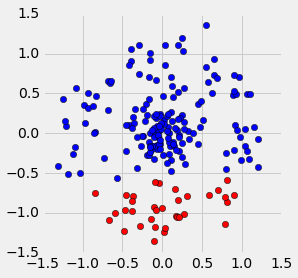

In [29]:
fig, ax = plt.subplots(1)
ax.plot(test_data[np.where(cls[:, 0]), 0], test_data[np.where(cls[:, 0]), 1], 'bo')
ax.plot(test_data[np.where(cls[:, 1]), 0], test_data[np.where(cls[:, 1]), 1], 'ro')
ax.set_aspect('equal')

## Another approach is a network with hidden layers

In [30]:
def init_weights(shape, init_method='xavier', xavier_params = (None, None)):
    if init_method == 'zeros':
        return tf.Variable(tf.zeros(shape, dtype=tf.float32))
    elif init_method == 'uniform':
        return tf.Variable(tf.random_normal(shape, stddev=0.01, dtype=tf.float32))
    else: #xavier
        (fan_in, fan_out) = xavier_params
        low = -4*np.sqrt(6.0/(fan_in + fan_out)) # {sigmoid:4, tanh:1} 
        high = 4*np.sqrt(6.0/(fan_in + fan_out))
        return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))
    

In [31]:
def train_hidden(train_data, 
                 train_labels, 
                 n_train=n_train,
                 num_labels=num_labels, batch_size=BATCH_SIZE,
                 num_epochs=NUM_EPOCHS, num_hidden=NUM_HIDDEN):

    # Get the shape of the training data.
    train_size, num_features = train_data.shape

    # This is where training samples and labels are fed to the graph.
    # These placeholder nodes will be fed a batch of training data at each
    # training step using the {feed_dict} argument to the Run() call below.
    x = tf.placeholder("float", shape=[None, num_features])
    y = tf.placeholder("float", shape=[None, num_labels])
    
    # Initialize the hidden weights and biases.
    w_hidden = init_weights(
        [num_features, num_hidden],
        'xavier',
        xavier_params=(num_features, num_hidden))

    b_hidden = init_weights([1, num_hidden],'zeros')

    # The hidden layer.
    hidden = tf.nn.tanh(tf.matmul(x, w_hidden) + b_hidden)

    # Initialize the output weights and biases.
    w_out = init_weights(
        [num_hidden, num_labels],
        'xavier',
        xavier_params=(num_hidden, num_labels))
    
    b_out = init_weights([1, num_labels],'zeros')

    # The output layer.
    y_hat = tf.nn.softmax(tf.matmul(hidden, w_out) + b_out)
    
    # Optimization.
    cross_entropy = -tf.reduce_sum(y * tf.log(y_hat))
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
    
    s = tf.Session() 
    tf.initialize_all_variables().run(session=s)
    print 'Initialized!'
    # Iterate and train:
    print('Training.')
    for step in xrange(num_epochs * train_size // batch_size):
        print(step),

        offset = (step * batch_size) % train_size
        batch_data = train_data[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size)]
        train_step.run(feed_dict={x: batch_data, y: batch_labels}, session=s)

        if offset >= train_size-batch_size:
            print
    return w_hidden, b_hidden, w_out, b_out, s


In [32]:
def evaluate_hidden(w_hidden, b_hidden, w_out, b_out, test_data, test_labels, s):
    test_size, num_features = train_data.shape

    # This is where training samples and labels are fed to the graph.
    # These placeholder nodes will be fed a batch of training data at each
    # training step using the {feed_dict} argument to the Run() call below.
    x = tf.placeholder("float", shape=[None, num_features])
    y = tf.placeholder("float", shape=[None, num_labels])

    hidden = tf.nn.tanh(tf.matmul(x, w_hidden) + b_hidden)
    y_hat = tf.nn.softmax(tf.matmul(hidden, w_out) + b_out)
    
    # Evaluation:
    correct_prediction = tf.equal(tf.argmax(y_hat, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    p_correct = accuracy.eval(feed_dict={x: test_data, y: test_labels}, session=s)
    return p_correct


In [33]:
train_data, test_data, train_labels, test_labels = generate_dataset(make_circles, n_train=1000, n_test=200, noise=0.2, factor=0.1)

In [34]:
w_hidden, b_hidden, w_out, b_out, s = train_hidden(train_data, train_labels)
evaluate_hidden(w_hidden, b_hidden, w_out, b_out, test_data, test_labels, s)

Initialized!
Training.
0 1 2 3 4 5 6 7 8 9
10 11 12 13 14 15 16 17 18 19
20 21 22 23 24 25 26 27 28 29
30 31 32 33 34 35 36 37 38 39
40 41 42 43 44 45 46 47 48 49


0.98000002

In [35]:
cls = np.round(s.run(tf.nn.softmax(tf.matmul(tf.nn.tanh(tf.matmul(test_data, w_hidden) + b_hidden), w_out) + b_out)))

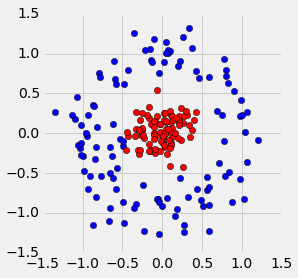

In [36]:
fig, ax = plt.subplots(1)
ax.plot(test_data[np.where(cls[:, 0]), 0], test_data[np.where(cls[:, 0]), 1], 'bo')
ax.plot(test_data[np.where(cls[:, 1]), 0], test_data[np.where(cls[:, 1]), 1], 'ro')
ax.set_aspect('equal')

In [37]:
train_data, test_data, train_labels, test_labels = generate_dataset(make_moons, n_train=1000, n_test=200, noise=0.2)

In [38]:
w_hidden, b_hidden, w_out, b_out, s = train_hidden(train_data, train_labels)
evaluate_hidden(w_hidden, b_hidden, w_out, b_out, test_data, test_labels, s)

Initialized!
Training.
0 1 2 3 4 5 6 7 8 9
10 11 12 13 14 15 16 17 18 19
20 21 22 23 24 25 26 27 28 29
30 31 32 33 34 35 36 37 38 39
40 41 42 43 44 45 46 47 48 49


0.94

In [39]:
cls = np.round(s.run(tf.nn.softmax(tf.matmul(tf.nn.tanh(tf.matmul(test_data, w_hidden) + b_hidden), w_out) + b_out)))

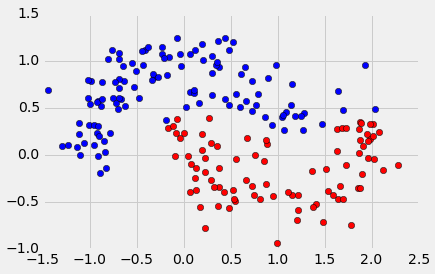

In [40]:
fig, ax = plt.subplots(1)
ax.plot(test_data[np.where(cls[:, 0]), 0], test_data[np.where(cls[:, 0]), 1], 'bo')
ax.plot(test_data[np.where(cls[:, 1]), 0], test_data[np.where(cls[:, 1]), 1], 'ro')
ax.set_aspect('equal')

In [98]:
class UniversalFunctionApproximator(object):
    """ Approximate any function using a neural network with a hidden layer"""
    def __init__(self, n_hidden=NUM_HIDDEN, batch_size=BATCH_SIZE,
                 n_epochs=NUM_EPOCHS):
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        # Initialize the weights for both layers:
        self.w_h = init_weights([1, n_hidden], 'xavier', xavier_params=(1, n_hidden))
        self.b_h = init_weights([1, n_hidden], 'zeros')
        self.w_o = init_weights([n_hidden, 1], 'xavier', xavier_params=(n_hidden, 1))
        self.b_o = init_weights([1, 1], 'zeros')
        
    def _ann(self, X):    
        """A two-layer network"""
        h = tf.nn.sigmoid(tf.matmul(X, self.w_h) + self.b_h)
        return tf.matmul(h, self.w_o) + self.b_o

    def fit(self, trainx, trainy):
        x = tf.placeholder(tf.float32, [None, 1], name="X")
        y = tf.placeholder(tf.float32, [None, 1], name="Y")
        y_hat = self._ann(x)
        #cross_entropy = -tf.reduce_sum(y * tf.log(y_hat))
        #train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
        train_step = tf.train.AdamOptimizer().minimize(tf.nn.l2_loss(y_hat - y))
        self.sess = tf.Session()
        self.sess.run(tf.initialize_all_variables())
        for i in range(self.n_epochs):
            for start, end in zip(range(0, len(trainx), self.batch_size), 
                                  range(self.batch_size, len(trainx), self.batch_size)):
                self.sess.run(train_step, feed_dict={x: trainx[start:end], y: trainy[start:end]})

    def predict(self, testx):
        return self.sess.run(self._ann(testx))

In [99]:
function_to_learn = lambda x: np.sin(x) + 0.1*np.random.randn(*x.shape)

In [112]:
ufa = UniversalFunctionApproximator(n_hidden=100)

In [113]:
num_examples = 1000
train_split = 0.8

In [114]:
all_x = np.float32(np.random.uniform(-2*np.pi, 2*np.pi, (1, num_examples))).T
np.random.shuffle(all_x)

train_size = int(num_examples*train_split)

trainx = all_x[:train_size]
testx = all_x[train_size:]

trainy = function_to_learn(trainx)
testy = function_to_learn(testx)

In [115]:
ufa.fit(trainx, trainy)

In [116]:
y_hat = ufa.predict(testx)

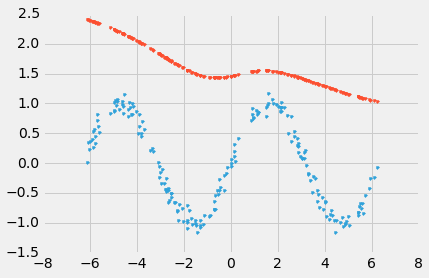

In [117]:
plt.plot(testx, testy, '.')
plt.plot(testx, y_hat, '.')